# Business Summary

This project demonstrates how unsupervised machine learning can be used to segment a customer base into distinct groups based on their purchasing behavior.

By leveraging clustering algorithms, we can move beyond a "one-size-fits-all" approach and identify key customer personas, such as "High-Value," "New," and "At-Risk" customers. These insights directly enable targeted marketing campaigns, personalized promotions, and proactive retention strategies to maximize profitability and customer loyalty.

**Methods Used**: K-Means Clustering, Principal Component Analysis (PCA) for visualization, and feature scaling.

#### **Note on Confidentiality**

This project was completed as part of my course at the University of Cambridge. To comply with academic policy, the raw dataset has been excluded and all specific identifiers have been anonymized. This notebook serves to demonstrate the analytical methodology.

# Data Preparation and Cleaning

In the following cells, the required libraries and datasets are downloaded and imported to start the actual work. Note that the link to the actual dataset has been deleted due to data confidentiality and can be provided separately.

In [ ]:
!pip install gdown

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Import KMeans function.
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from scipy.cluster.hierarchy import dendrogram, linkage

The .csv file is imported into a pandas dataframe. The link to the dataset is **not** included to respect data confidentiality. It can be made available upon request.

In [ ]:
!gdown ''
raw_data = pd.read_csv('/content/CUSTOMERS_CLEAN.csv')

The first 10 rows of the created dataframe are shown

In [ ]:
raw_data.head(10)

Missing values in the dataset are identified

In [ ]:
raw_data.isnull().sum()

In [ ]:
raw_data.shape

(951669, 20)

Duplicate rows are removed from the dataset

In [ ]:
raw_data.drop_duplicates(keep='first',inplace=True)
raw_data.shape

(951648, 20)

The columns containing missing values are removed from the dataset, as they are not necessary to create the required features

In [ ]:
data_less_cols = raw_data.drop(columns=['City','Postal_Code','State_Province'])
data_less_cols.shape

(951648, 17)

Another dataset (clean) is created for further computations. In the columns "Unit Cost" and "Total Revenue", the format is converted from string to float

In [ ]:
clean = data_less_cols.copy()
clean['Unit Cost'] = clean['Unit Cost'].apply(lambda x: float(x[1:].replace(",","")))
clean['Total Revenue'] = clean['Total Revenue'].apply(lambda x: float(x[1:].replace(",","")))

In the columns "Order Date", "Delivery Date" and "Customer Birth Date", the format is converted from string to datetime object by means of the datetime pandas function

In [ ]:
from datetime import datetime
clean['Order_Date'] = pd.to_datetime(clean['Order_Date'], format='%d%b%Y')
clean['Delivery_Date'] = pd.to_datetime(clean['Delivery_Date'], format='%d%b%Y')
clean['Customer_BirthDate'] = pd.to_datetime(clean['Customer_BirthDate'], format='%d%b%Y')

Some descriptive statistics are generated

In [ ]:
clean.describe()

A column representing the customer age is created by using the pandas datetime functions

In [ ]:
today = pd.Timestamp('now')
clean['Customer_Age'] = (today - clean['Customer_BirthDate']).dt.days // 365

Delivery date, customers date of birth and customer ages are plotted with histogram to perform some "sanity checks" on the data

<Axes: xlabel='Delivery_Date', ylabel='Count'>

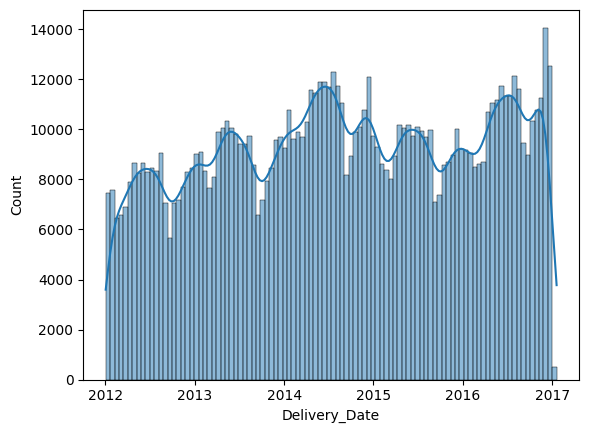

In [ ]:
sns.histplot(data = clean['Delivery_Date'], kde = True)

<Axes: xlabel='Customer_BirthDate', ylabel='Count'>

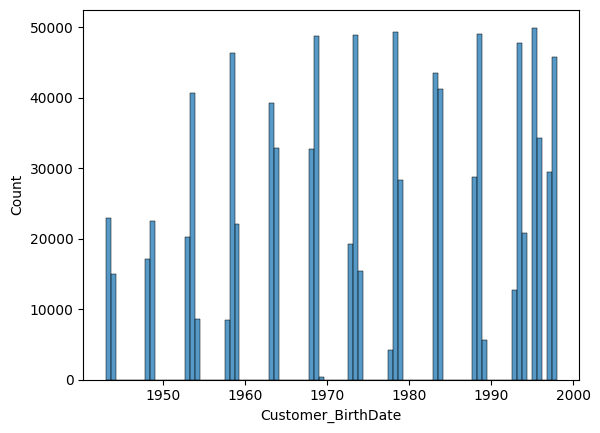

In [ ]:
sns.histplot(data = clean['Customer_BirthDate'])

<Axes: xlabel='Customer_Age', ylabel='Count'>

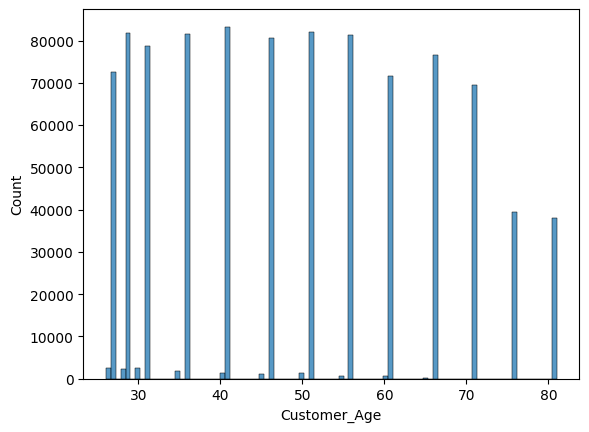

In [ ]:
sns.histplot(data = clean['Customer_Age'])

This cell was meant at performing some sanity checks on the functionality of the pandas datetime package

In [ ]:
#some data exploring...
test_df_ggg = pd.DataFrame(columns=['order count','max order date','min order date','test', 'diff', 'check'])
test_df_ggg['order count'] = clean.groupby('Customer ID')['Order_Date'].count()
test_df_ggg['max order date'] = clean.groupby('Customer ID')['Order_Date'].max().dt.year
test_df_ggg['min order date'] = clean.groupby('Customer ID')['Order_Date'].min().dt.year
test_df_ggg['test'] = (test_df_ggg['max order date'] == test_df_ggg['min order date'])
test_df_ggg['diff'] = test_df_ggg['max order date'] - test_df_ggg['min order date']
test_df_ggg['check'] = clean.groupby('Customer ID')['Customer_BirthDate'].apply(lambda x: x.value_counts().count())

In [ ]:
test_df_ggg['check'].value_counts()

check
1    68300
Name: count, dtype: int64

# Features Engineering

The new features are created in this cell as follows:

(1) The "Frequency" feature is created by counting the number of orders for each customer and dividing them by the overall period of time (4 years) to obain an yearly average purchase frequency

(2) The "Recency" feature is created as the difference (in days) between today's date and the date of the last purchase from a specific customer

(3) The "CLV" feature is created as the sum of the "Total Revenue" feature for each customer

(4) The "Average Unit Cost" feature is created by averaging the price of the units purchased by each customer

(5) The "Customer Age" feature is simply extracted by the previous cell's calculation

In [ ]:
given_time = clean['Order_Date'].max().year - clean['Order_Date'].min().year
new_df = pd.DataFrame(columns=['Frequency','Recency','CLV','Average Unit Cost','Customer Age'])
#Customer Age
new_df['Customer Age'] = clean.groupby('Customer ID')['Customer_Age'].apply(lambda x: x.value_counts().index[0])
#Frequency
new_df['Frequency'] = clean.groupby('Customer ID')['Delivery_Date'].count()/given_time
#Recency
new_df['Recency'] = (datetime.now()-clean.groupby('Customer ID')['Delivery_Date'].max()).dt.days
#Average Unit Cost
new_df['Average Unit Cost'] = clean.groupby('Customer ID')['Unit Cost'].mean()
#CLV
new_df['CLV'] = clean.groupby('Customer ID')['Total Revenue'].sum()

Some descriptive statistics for the newly created features is generated

In [ ]:
new_df.describe()

Frequency       Recency           CLV  Average Unit Cost  \
count  68300.000000  68300.000000  68300.000000       68300.000000   
mean       3.483338   3268.399971   1950.148420          78.895675   
std        2.832202    414.289931   1719.916365          38.005259   
min        0.250000   2882.000000      0.630000           0.500000   
25%        1.500000   2946.000000    696.000000          57.579792   
50%        2.750000   3090.000000   1497.400000          73.450000   
75%        4.750000   3440.000000   2709.845000          92.515260   
max       30.250000   4726.000000  18860.960000        1463.500000   

       Customer Age  
count  68300.000000  
mean      51.088170  
std       17.484686  
min       26.000000  
25%       36.000000  
50%       51.000000  
75%       66.000000  
max       81.000000

Outliers are detected and eliminated in the cell below, using an Isolation Forest algorithm with 1% Contamination Factor.

In [ ]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest.fit(new_df)
anomaly_ISO = iso_forest.predict(new_df)
new_df_no_outliers = new_df.iloc[anomaly_ISO==1,:]
new_df_no_outliers.describe()

Frequency       Recency           CLV  Average Unit Cost  \
count  67617.000000  67617.000000  67617.000000       67617.000000   
mean       3.416393   3266.308029   1903.190717          77.967129   
std        2.637523    410.719295   1595.593963          33.811706   
min        0.250000   2882.000000      0.630000           0.500000   
25%        1.500000   2946.000000    694.100000          57.430769   
50%        2.750000   3090.000000   1488.900000          73.263636   
75%        4.750000   3437.000000   2683.850000          92.250000   
max       18.250000   4726.000000  12846.700000         529.566667   

       Customer Age  
count  67617.000000  
mean      51.087848  
std       17.468513  
min       26.000000  
25%       36.000000  
50%       51.000000  
75%       66.000000  
max       81.000000

Each of the new features is plotted separately with histograms and boxplots

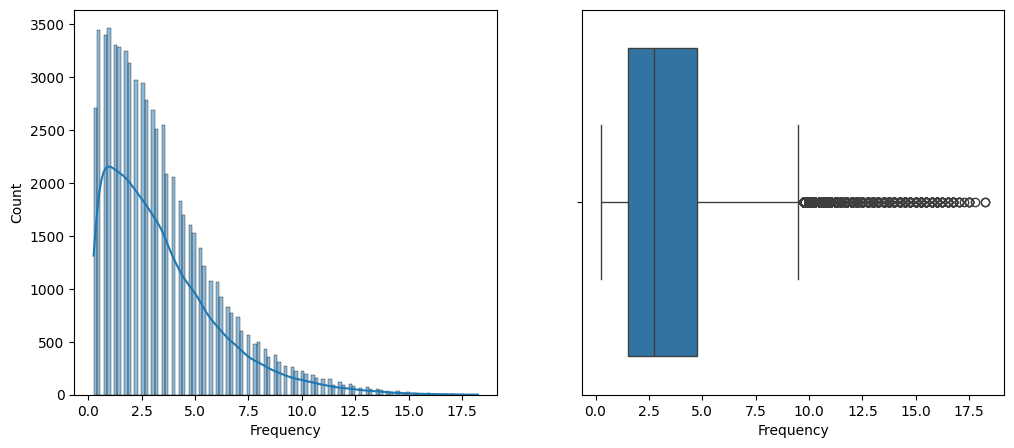

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualise data with histogram.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data = new_df_no_outliers['Frequency'], kde = True)
plt.subplot(1, 2, 2)
sns.boxplot(x = new_df_no_outliers['Frequency'])
plt.show()
plt.tight_layout()

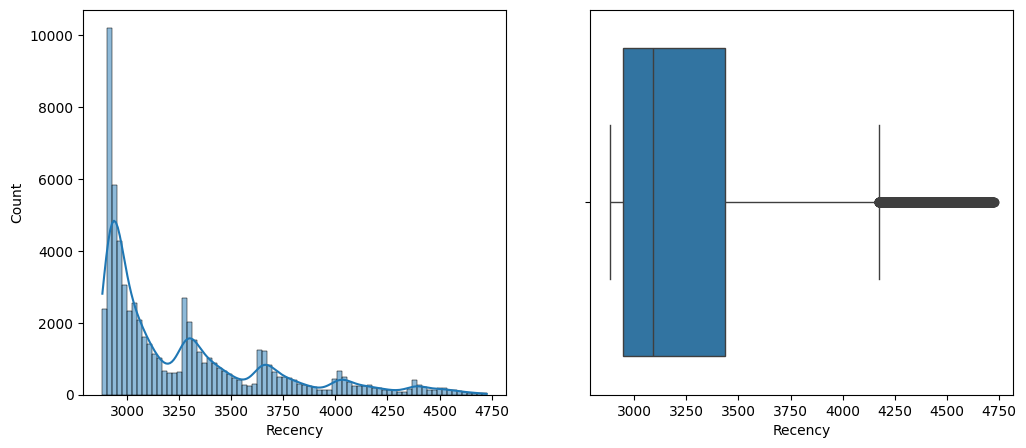

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualise data with histogram.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data = new_df_no_outliers['Recency'], kde = True)
plt.subplot(1, 2, 2)
sns.boxplot(x = new_df_no_outliers['Recency'])
plt.show()
plt.tight_layout()

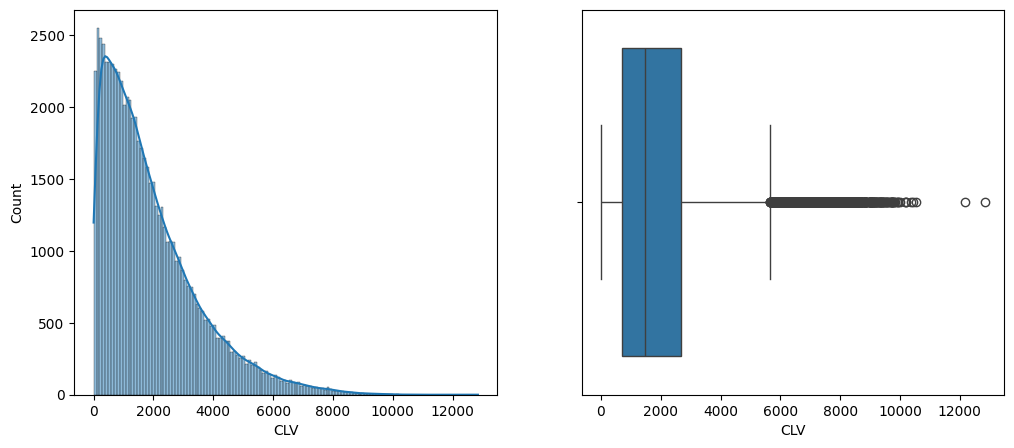

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualise data with histogram.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data = new_df_no_outliers['CLV'], kde = True)
plt.subplot(1, 2, 2)
sns.boxplot(x = new_df_no_outliers['CLV'])
plt.show()
plt.tight_layout()

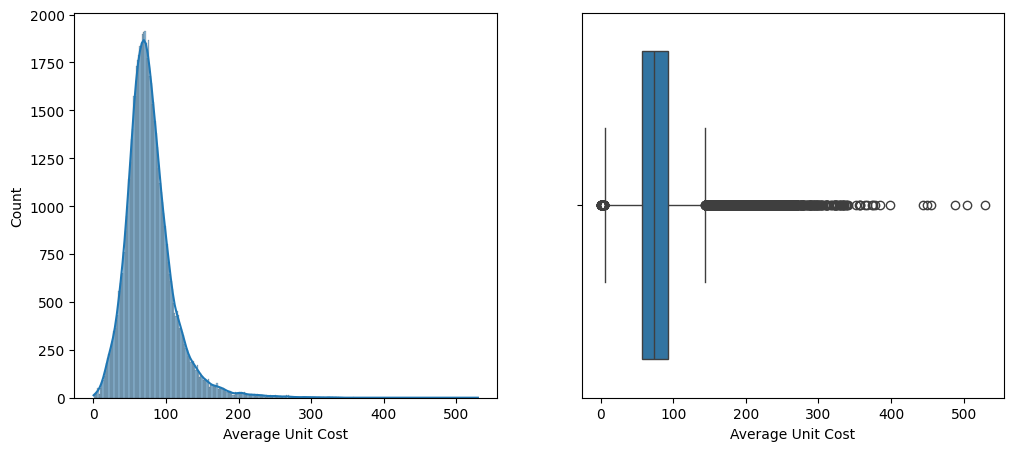

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualise data with histogram.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data = new_df_no_outliers['Average Unit Cost'], kde = True)
plt.subplot(1, 2, 2)
sns.boxplot(x = new_df_no_outliers['Average Unit Cost'])
plt.show()
plt.tight_layout()

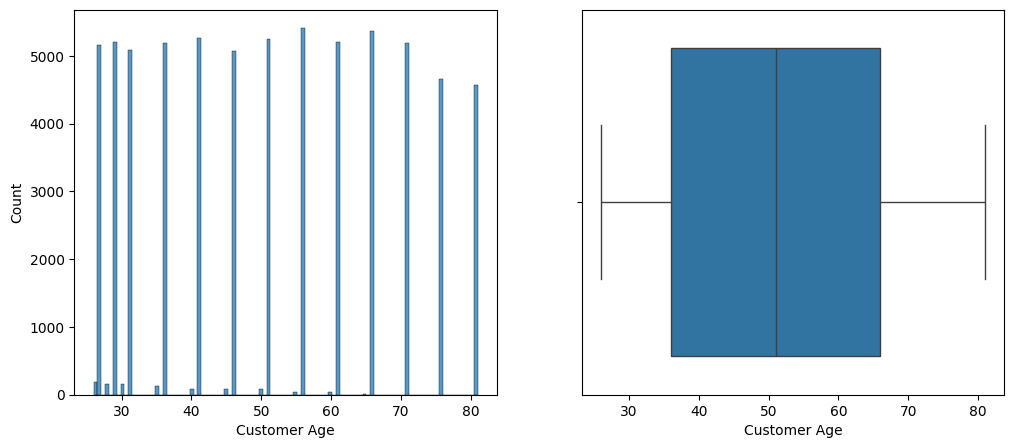

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualise data with histogram.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data = new_df_no_outliers['Customer Age'], bins=100)
plt.subplot(1, 2, 2)
sns.boxplot(x = new_df_no_outliers['Customer Age'])
plt.show()
plt.tight_layout()

And the new features are plotted against each other using scatterplots

<Axes: xlabel='Frequency', ylabel='Recency'>

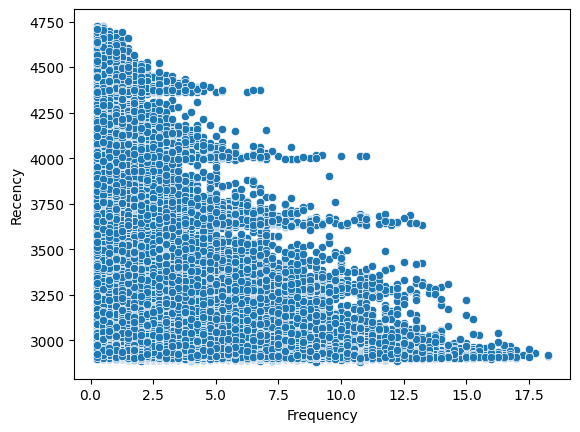

In [ ]:
sns.scatterplot(data=new_df_no_outliers, x='Frequency', y='Recency')

<Axes: xlabel='Frequency', ylabel='CLV'>

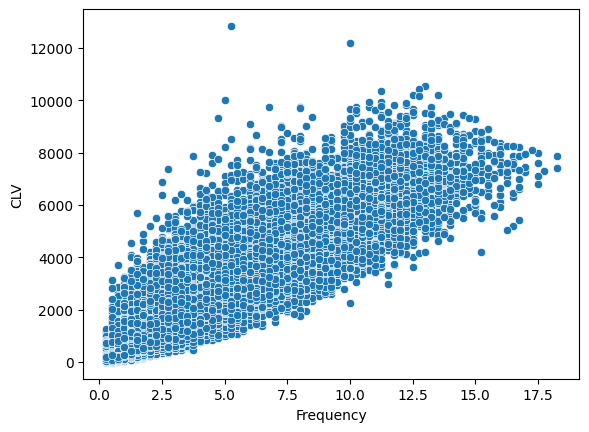

In [ ]:
sns.scatterplot(data=new_df_no_outliers, x='Frequency', y='CLV')

<Axes: xlabel='Frequency', ylabel='Average Unit Cost'>

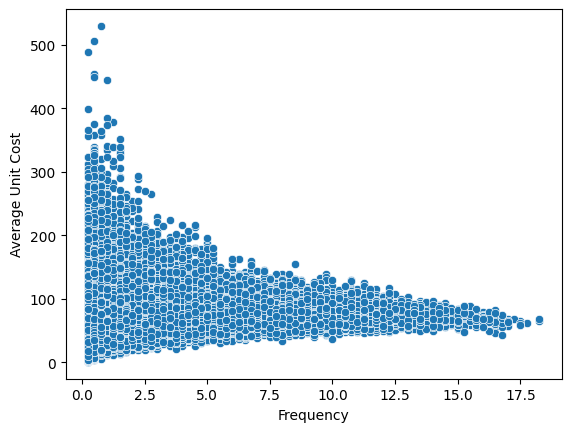

In [ ]:
sns.scatterplot(data=new_df_no_outliers, x='Frequency', y='Average Unit Cost')

<Axes: xlabel='CLV', ylabel='Average Unit Cost'>

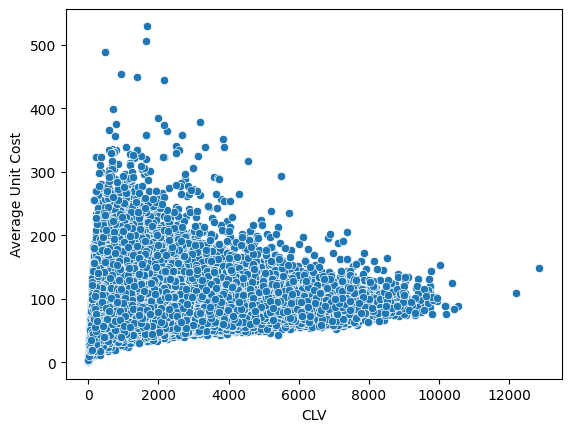

In [ ]:
sns.scatterplot(data=new_df_no_outliers, x='CLV', y='Average Unit Cost')

<Axes: xlabel='Frequency', ylabel='Customer Age'>

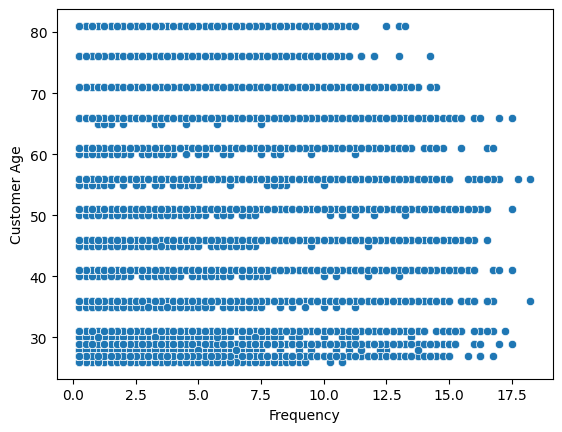

In [ ]:
sns.scatterplot(data=new_df_no_outliers, x='Frequency', y='Customer Age')

A correlation analysis between features was performed and is shown below. A high correlation is found between the features "Frequency" and "CLV". This is somehow expected since a customer who buys more frequently also generates more revenue. Due to the high correlation and the risk of multicollinearity, it would be interesting to perform the analysis with and without the variable "CLV" and to compare the results. However, this is beyond the scope of this work.

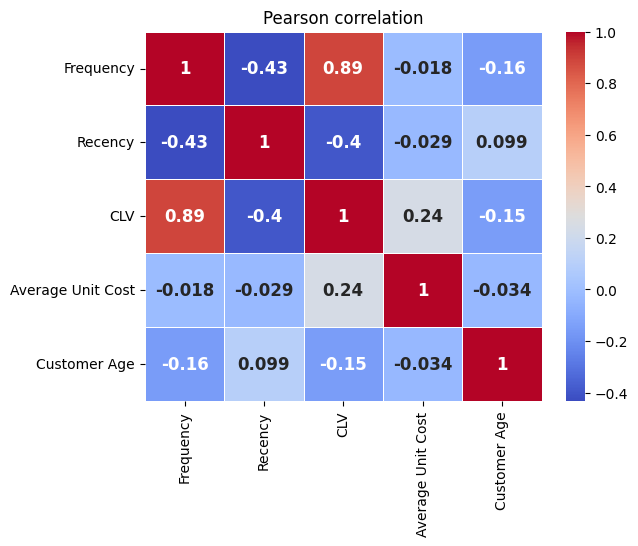

In [ ]:
corr_pearson = new_df_no_outliers.corr(method='pearson')
sns.heatmap(corr_pearson,
            annot=True,
            cmap='coolwarm',
            linewidths=0.5,
            annot_kws={"fontsize": 12, "fontweight": "bold"})
plt.title('Pearson correlation')
plt.show()

In [ ]:
test_df = new_df_no_outliers.copy()
X = test_df.to_numpy()
X_scaled = StandardScaler().fit_transform(X)
X_scaled_df = pd.DataFrame(data=X_scaled, columns=new_df.columns)
X_scaled_df.describe().round(2)

Frequency   Recency       CLV  Average Unit Cost  Customer Age
count   67617.00  67617.00  67617.00           67617.00      67617.00
mean       -0.00     -0.00     -0.00               0.00         -0.00
std         1.00      1.00      1.00               1.00          1.00
min        -1.20     -0.94     -1.19              -2.29         -1.44
25%        -0.73     -0.78     -0.76              -0.61         -0.86
50%        -0.25     -0.43     -0.26              -0.14         -0.01
75%         0.51      0.42      0.49               0.42          0.85
max         5.62      3.55      6.86              13.36          1.71

# Hierarchical Clustering

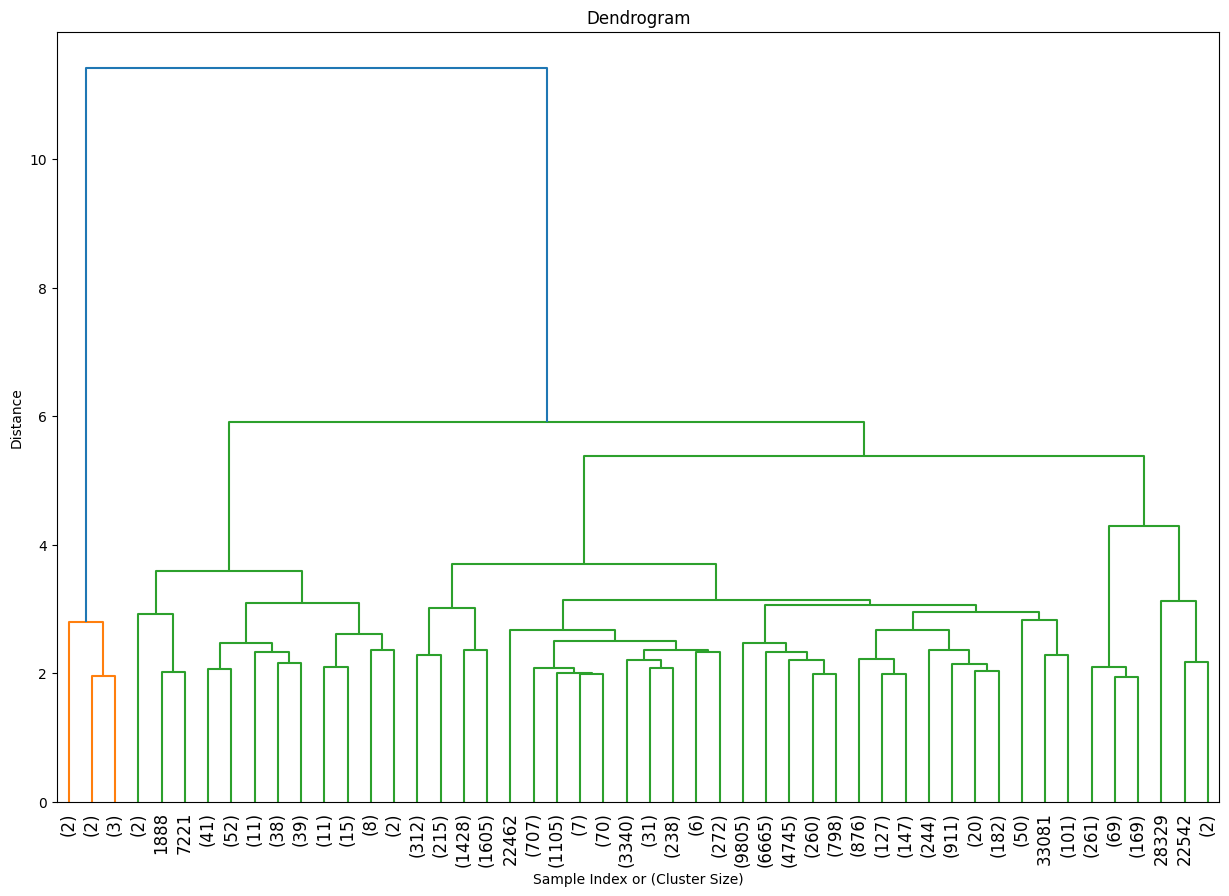

In [ ]:
X_sampled_df = X_scaled_df.sample(n=35000, random_state=42).reset_index(drop=True)
X_sampled = X_sampled_df.to_numpy()

#Creating the linkage matrix and plotting the dendrogram
Z = linkage(X_sampled, method='average')
plt.figure(figsize=(15, 10))
dendrogram(Z, truncate_mode='lastp', p=50, leaf_rotation=90, leaf_font_size=12)
plt.title('Dendrogram')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.show()

# Clusters Number Selection



In the section below, the elbow method was implemented to calculate the optimal number of clusters for the specified dataset.

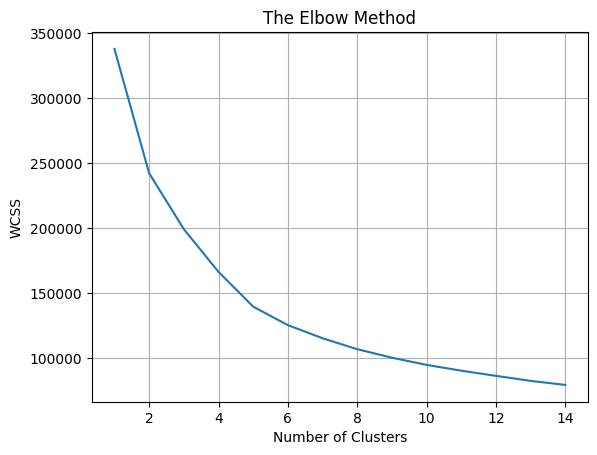

In [ ]:
# Elbow method: try different k.
n_clusters_elbow = 15
wcss=[]
for i in range(1,n_clusters_elbow):
    kmeans=KMeans(n_clusters=i, init='k-means++',random_state=42, n_init = 10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,n_clusters_elbow),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In the section below, the silhouette method was carried out to complement the results from the elbow method. A range of possible clusters number was chosen between 2 and 8, to balance accuracy and computational costs.

In [ ]:
#define range of clusters numbers
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

For n_clusters = 2 The average silhouette_score is : 0.2612764874512204
For n_clusters = 3 The average silhouette_score is : 0.2421439752154582
For n_clusters = 4 The average silhouette_score is : 0.24978978075204536
For n_clusters = 5 The average silhouette_score is : 0.262206990506426
For n_clusters = 6 The average silhouette_score is : 0.24265933282756608
For n_clusters = 7 The average silhouette_score is : 0.23148973401054776
For n_clusters = 8 The average silhouette_score is : 0.23095011955855402


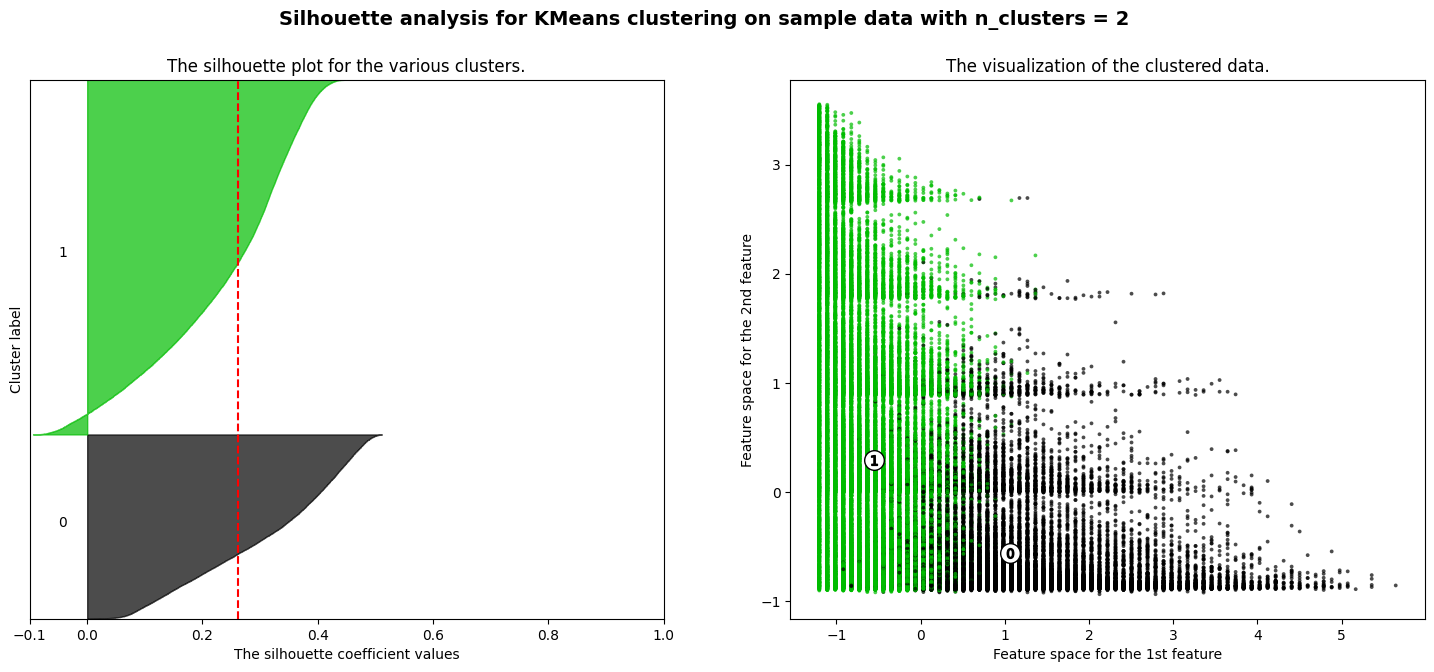

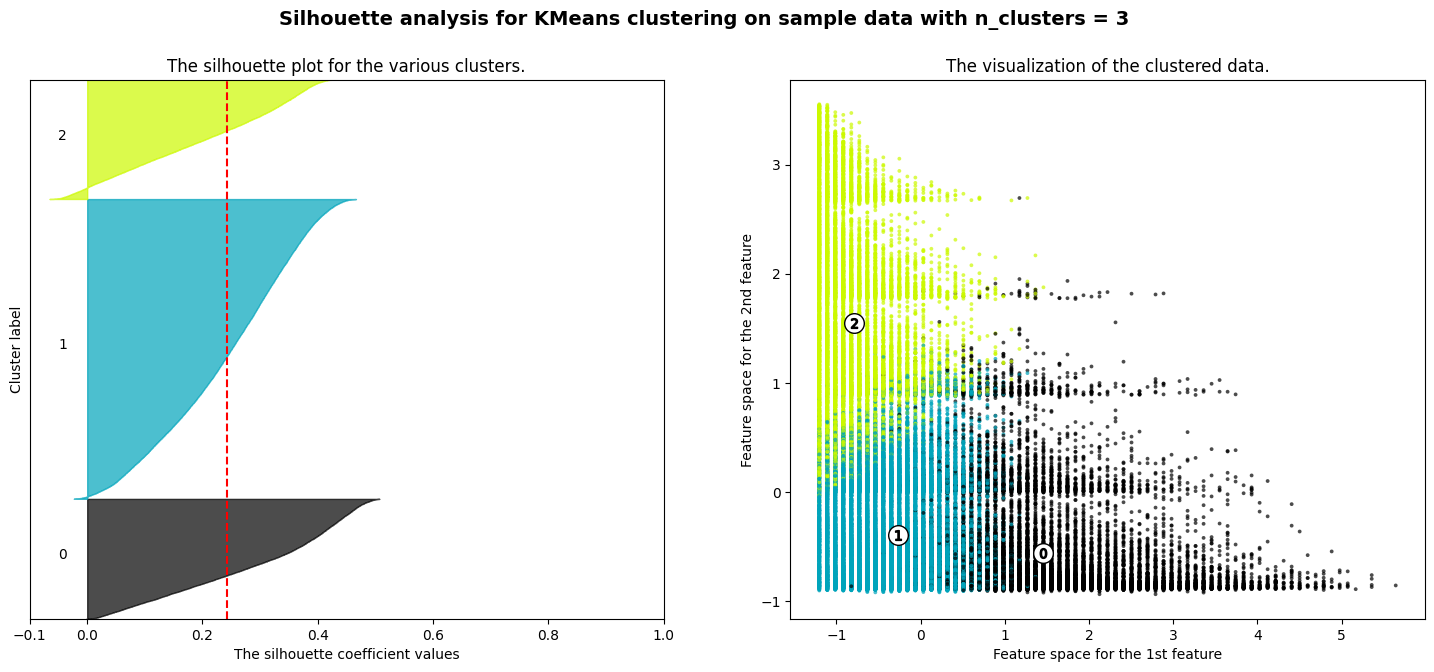

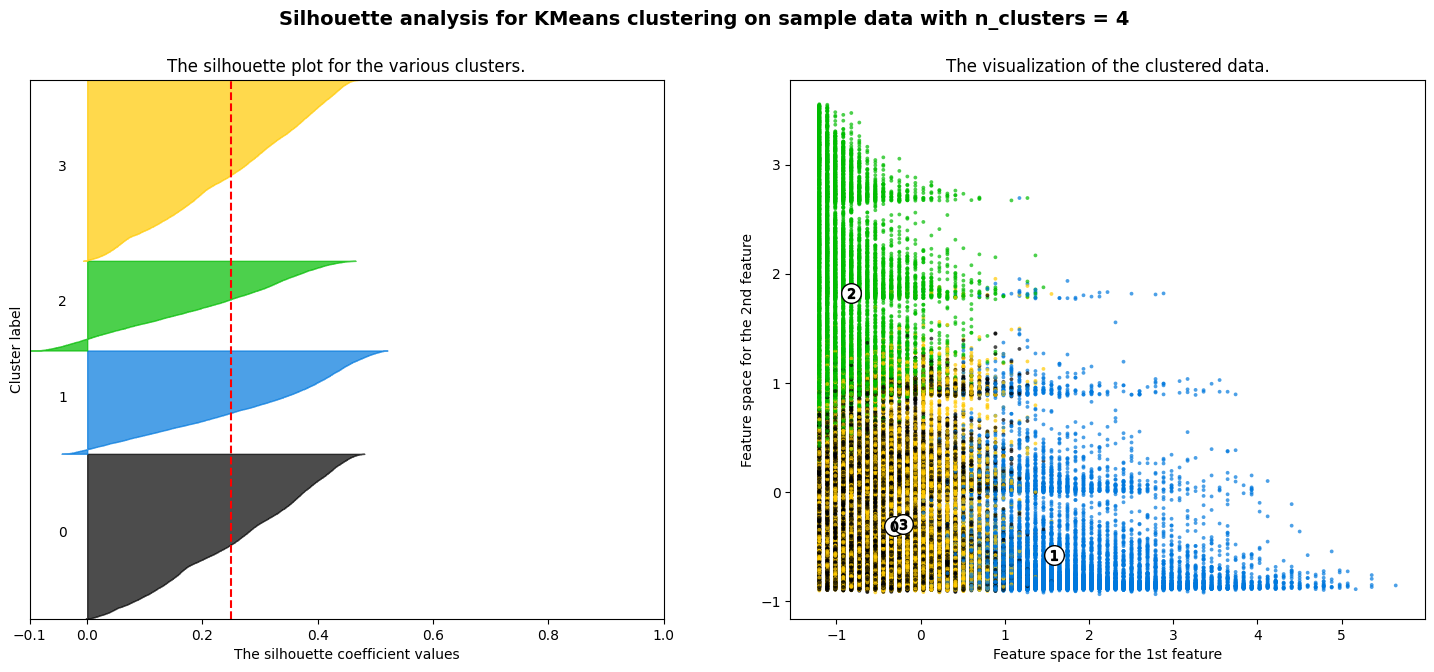

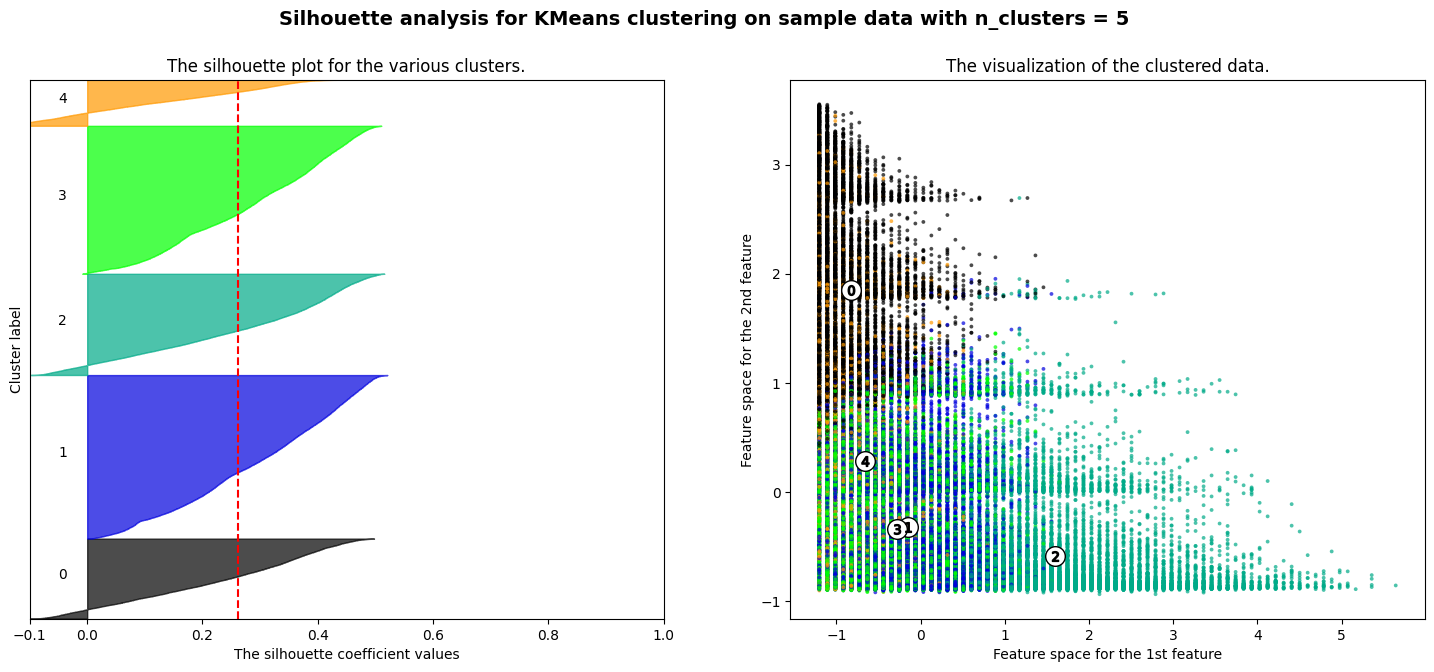

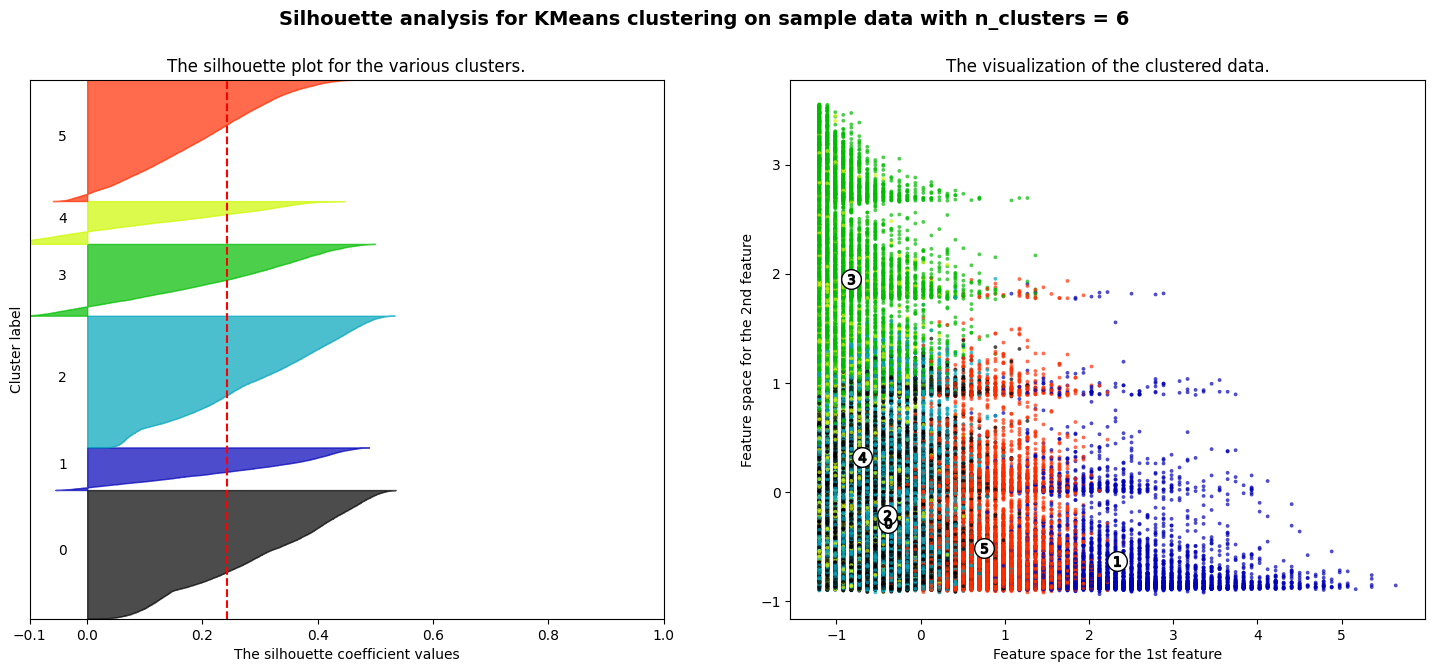

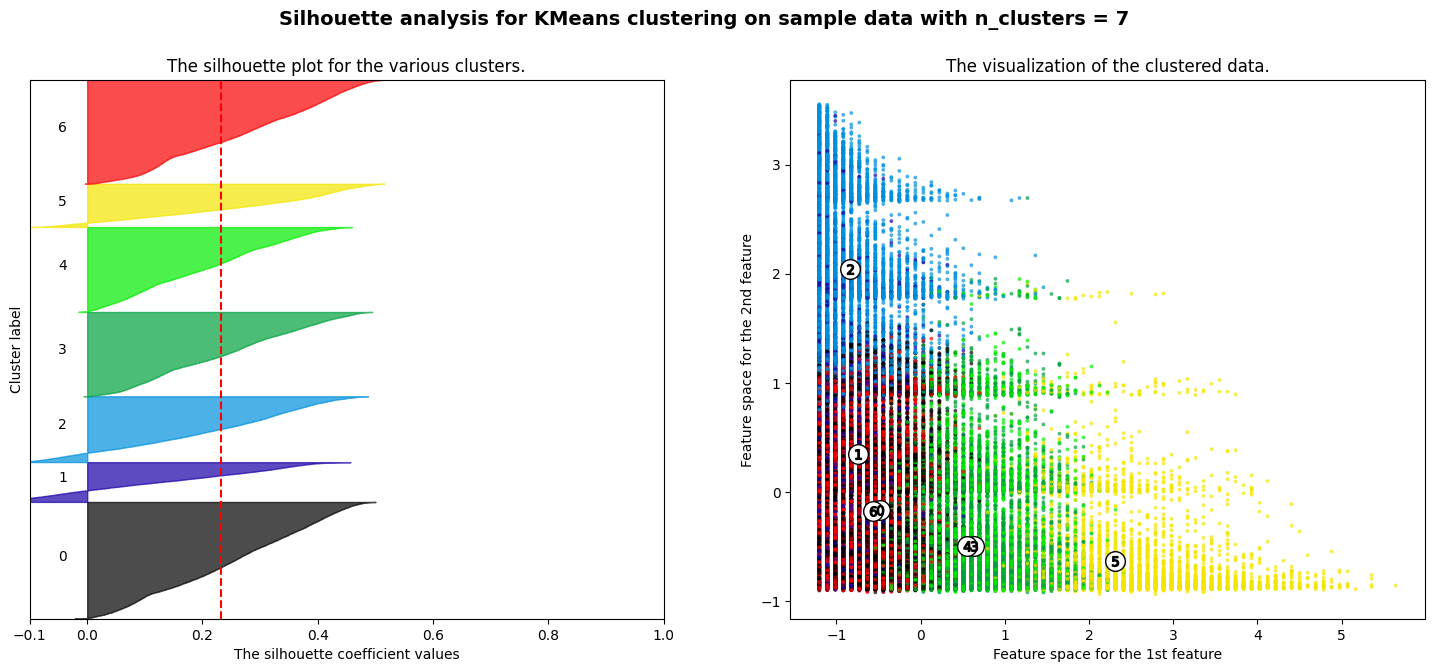

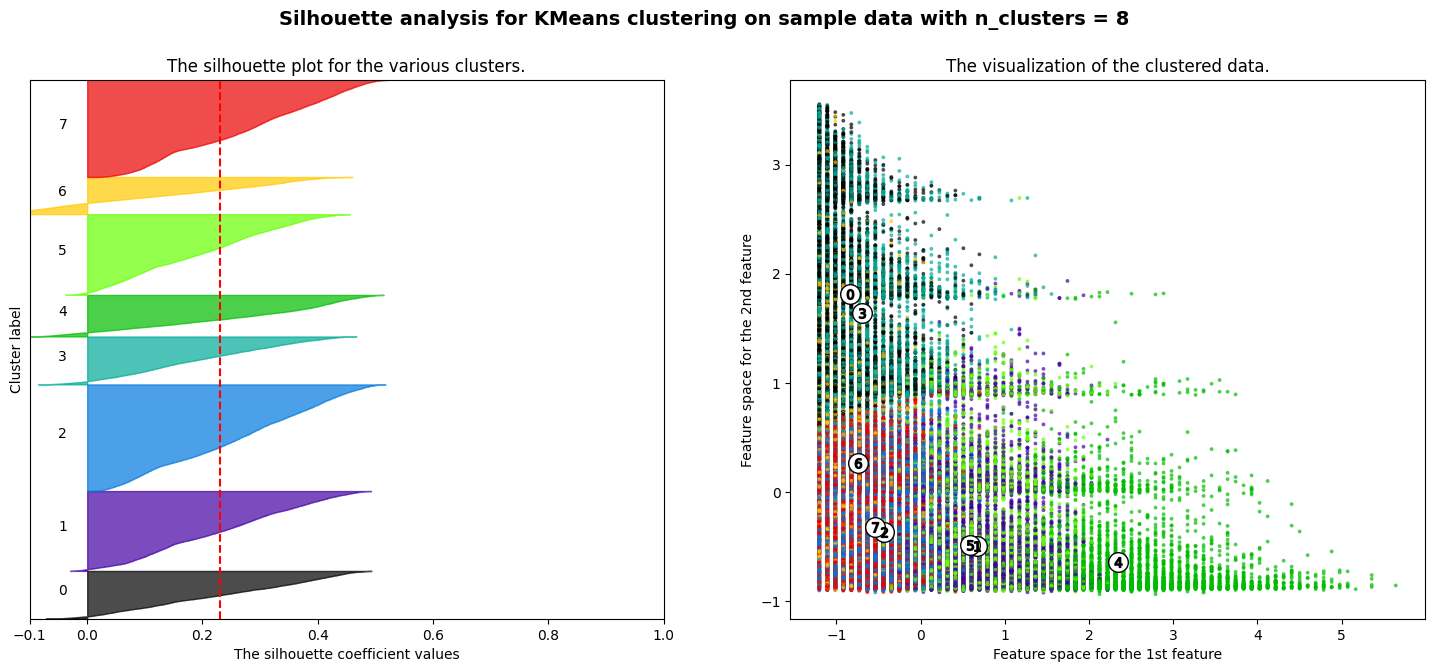

In [ ]:
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns.
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot.
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1].
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init = 10)
    cluster_labels = clusterer.fit_predict(X_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them.
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle.
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot.
        y_lower = y_upper + 10  # 10 for the 0 samples.

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values.
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks.
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed.
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters.
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers.
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# K-means Clusering



After choosing the number of clusters based on the elbow and silhouette methods, the K-Means procedure was carried out. Afterwards, a new dataframe named ***cluster_df*** was created with two columns: the first column contains the customers ID and the second contains the number of the cluster that specific customer belongs to.

In [ ]:
# Set the Number of clusters
n_clusters = 5

# Perform KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_scaled)

# Find the centroids
centroids = kmeans.cluster_centers_

# Calculate the Euclidean distances for each point to its cluster centroid
#distances = pairwise_distances(new_df, kmeans.cluster_centers_[kmeans.labels_], metric='euclidean')

# Assign clusters back to the original DataFrame
test_df['Cluster'] = kmeans.labels_

#Create new dataframe
cluster_df = pd.DataFrame(columns=['Customer ID','Cluster'])
cluster_df['Customer ID'] = test_df.index
cluster_df['Cluster'] = kmeans.labels_

# Assign Euclidean distances back to the original DataFrame
#test_df['euclidean_distance'] = distances.diagonal()

# Now 'df' has two new columns: 'cluster' and 'euclidean_distance'
cluster_df.head(10)

Customer ID  Cluster
0            1        3
1            3        0
2            4        1
3            5        0
4            6        4
5            7        0
6            9        3
7           10        3
8           11        1
9           12        0

The same scatterplots as the features engineering section are provided, with the colour of the datapoints representing the cluster they belong to.

<Axes: xlabel='Frequency', ylabel='Recency'>

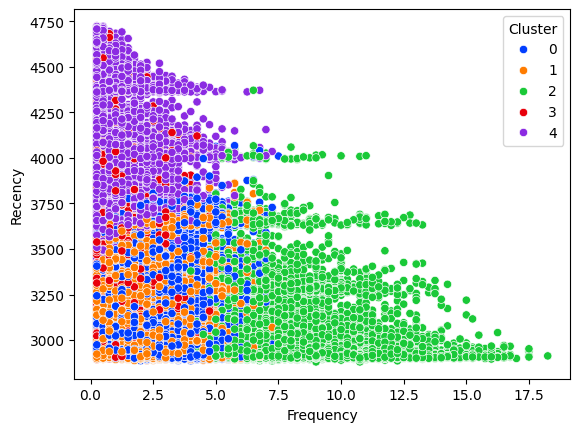

In [ ]:
sns.scatterplot(data=test_df, x='Frequency', y='Recency',hue='Cluster',palette='bright')

<Axes: xlabel='Frequency', ylabel='CLV'>

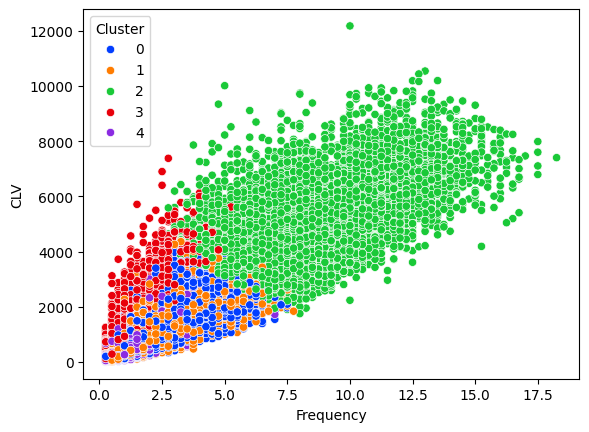

In [ ]:
sns.scatterplot(data=test_df, x='Frequency', y='CLV',hue='Cluster',palette='bright')

<Axes: xlabel='Frequency', ylabel='Average Unit Cost'>

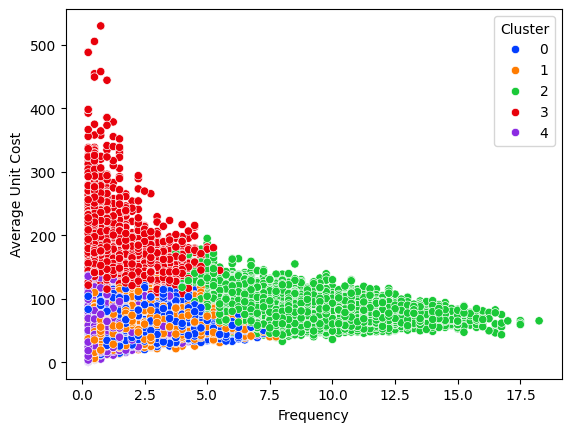

In [ ]:
sns.scatterplot(data=test_df, x='Frequency', y='Average Unit Cost',hue='Cluster',palette='bright')

<Axes: xlabel='Frequency', ylabel='Customer Age'>

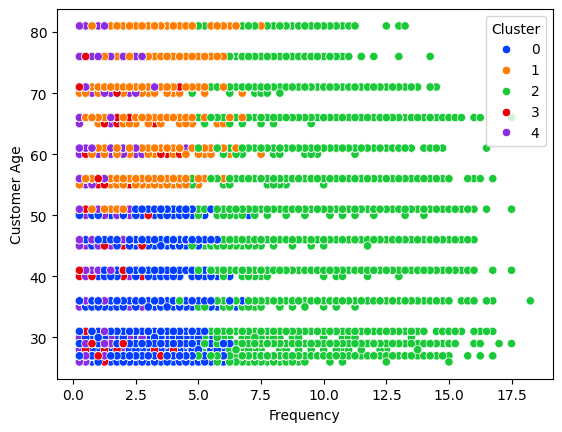

In [ ]:
sns.scatterplot(data=test_df, x='Frequency', y='Customer Age',hue='Cluster',palette='bright')

Each of the five features is now plotted independently against the cluster number using boxplots.

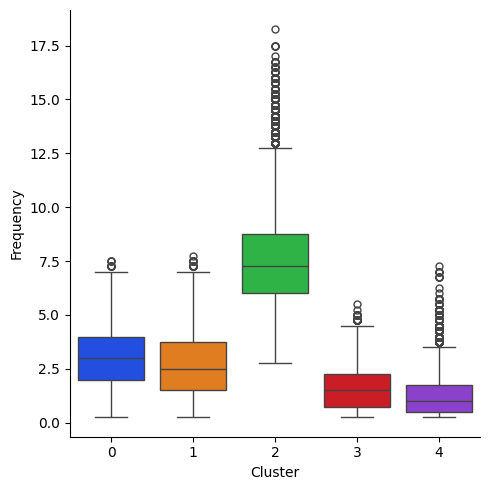

In [ ]:
sns.catplot(kind='box', data=test_df,
           y='Frequency', x='Cluster', hue='Cluster', palette="bright", sharey=False, legend=False)
plt.tight_layout()
plt.show()

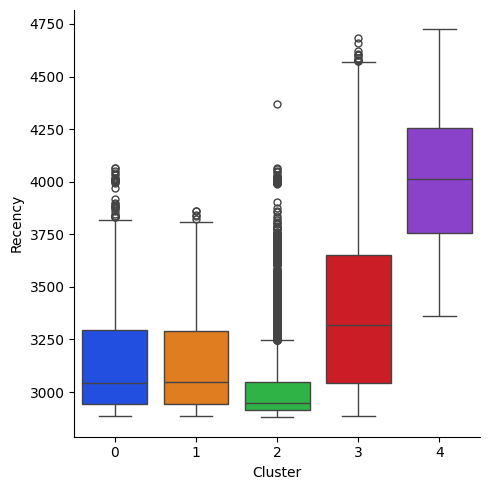

In [ ]:
sns.catplot(kind='box', data=test_df,
           y='Recency', x='Cluster', hue='Cluster', palette="bright", sharey=False, legend=False)
plt.tight_layout()
plt.show()

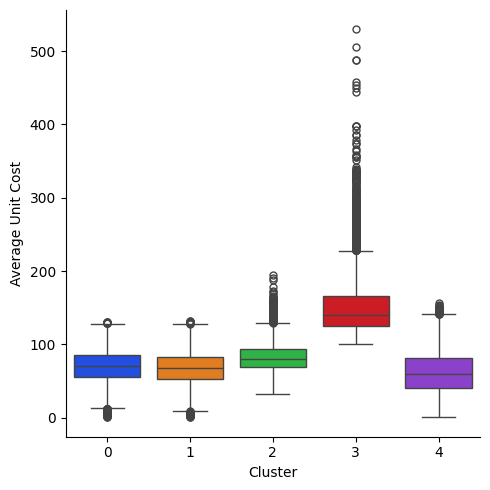

In [ ]:
sns.catplot(kind='box', data=test_df,
           y='Average Unit Cost', x='Cluster', hue='Cluster', palette="bright", sharey=False, legend=False)
plt.tight_layout()
plt.show()

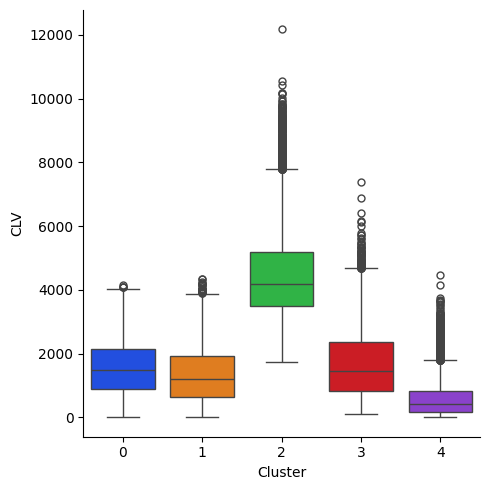

In [ ]:
sns.catplot(kind='box', data=test_df,
           y='CLV', x='Cluster', hue='Cluster', palette="bright", sharey=False, legend=False)
plt.tight_layout()
plt.show()

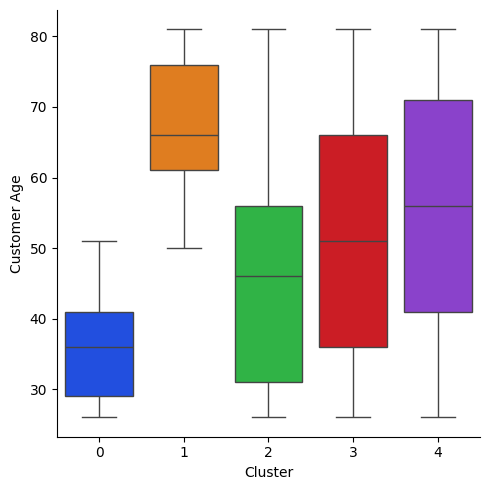

In [ ]:
sns.catplot(kind='box', data=test_df,
           y='Customer Age', x='Cluster', hue='Cluster', palette="bright", sharey=False, legend=False)
plt.tight_layout()
plt.show()

# 2D Clusters Visualization using PCA and TSNE

To help visualize the data and the clusters on a 2D plot, a Principal Components Analysis and a TSNE were performed with two components using the sci-kit learn library.

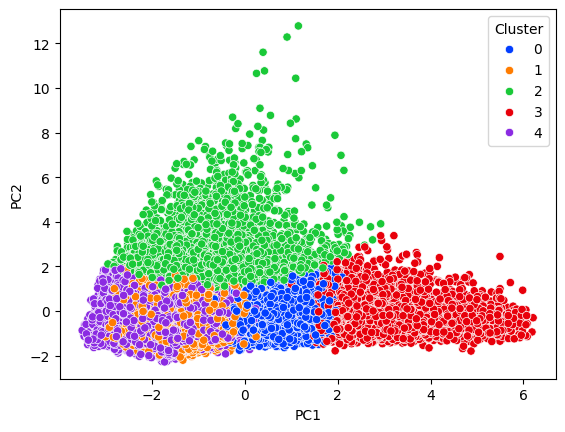

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
sns.scatterplot(x=X_pca[:,0],y=X_pca[:,1],hue=test_df['Cluster'],palette='bright')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.4491496  0.20508655]


After several experiments, a value of 40 for the perplexity parameter was chosen as it provides a good compromise between local and global variations.

TSNE transformed data shape: (67617, 2)
TSNE transformed data type: <class 'numpy.ndarray'>


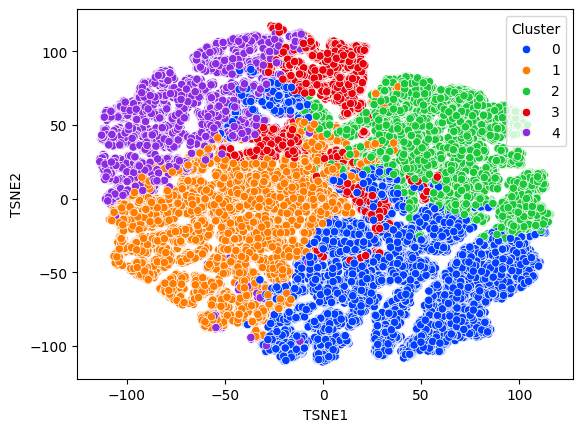

In [ ]:
# Transform the data with t-SNE.
TSNE_model = TSNE(n_components=2, perplexity=40.0)
TSNE_transformed_data = TSNE_model.fit_transform(X_scaled)

# View the shape and data type.
print("TSNE transformed data shape:", TSNE_transformed_data.shape)
print("TSNE transformed data type:", type(TSNE_transformed_data))
###
sns.scatterplot(x=TSNE_transformed_data[:,0],y=TSNE_transformed_data[:,1],hue=test_df['Cluster'],palette='bright')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

# Conclusions

While the underlying data does not present perfectly distinct groupings, a detailed analysis of the five identified clusters reveals actionable insights for targeted customer engagement.

**1. The Core Customer Segments (Clusters 2 & 3)**

Two groups form the commercial core of the customer base. Cluster 2 represents our high-frequency, high-revenue customers who are younger and have purchased recently. In contrast, Cluster 3 contains customers who purchase less frequently but buy higher-value items. These distinct profiles are ideal for tailored marketing campaigns focused on their specific purchasing habits and product interests.

**2. The Potential Churn Segment (Cluster 4)**

Cluster 4 is primarily composed of older customers whose purchasing activity has declined, suggesting they may be at risk of leaving the customer base. It is strongly recommended to launch a re-engagement initiative to investigate the reasons for this behavior and prevent potential churn.

**3. The Age-Differentiated Segment (Clusters 0 & 1)**

Clusters 0 and 1 are very similar in behavior, containing customers who recently bought lower-priced items. The primary discriminating feature between them is age. It is the analyst’s recommendation that these two clusters should either be merged for general marketing or, preferably, be the subject of age-specific campaigns to better target their unique needs.

**4. Recommendations for Future Analysis**

The original dataset also contained valuable geographical and membership information. Incorporating these features in a future iteration of this model would likely provide deeper, more granular insights into customer behavior and further enhance segmentation accuracy.